<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

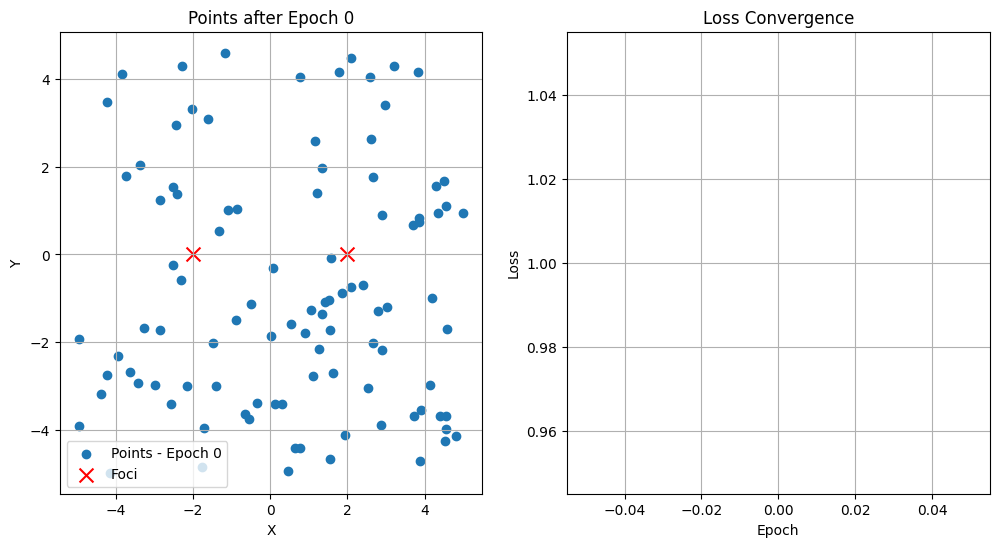

Epoch 0: Loss = 1.000000


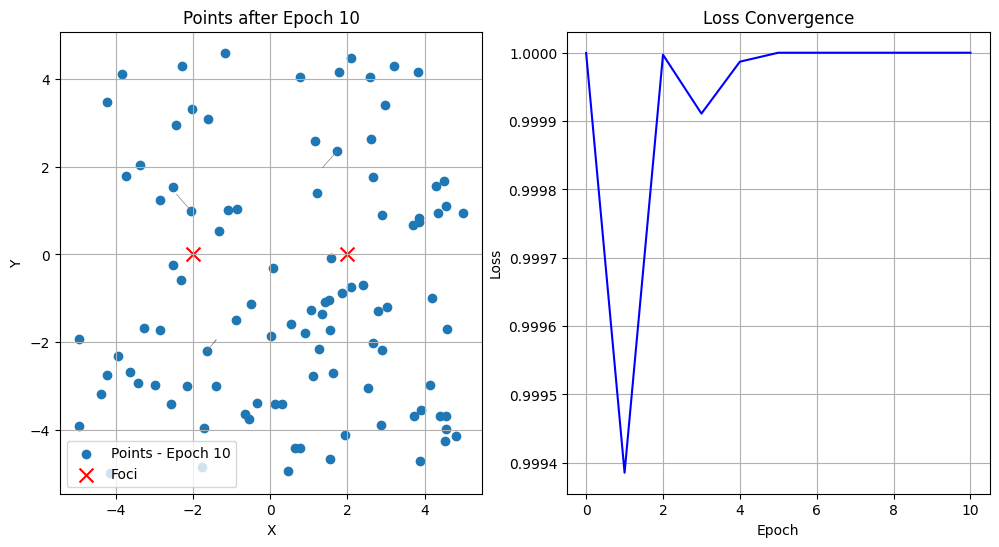

Epoch 10: Loss = 1.000000


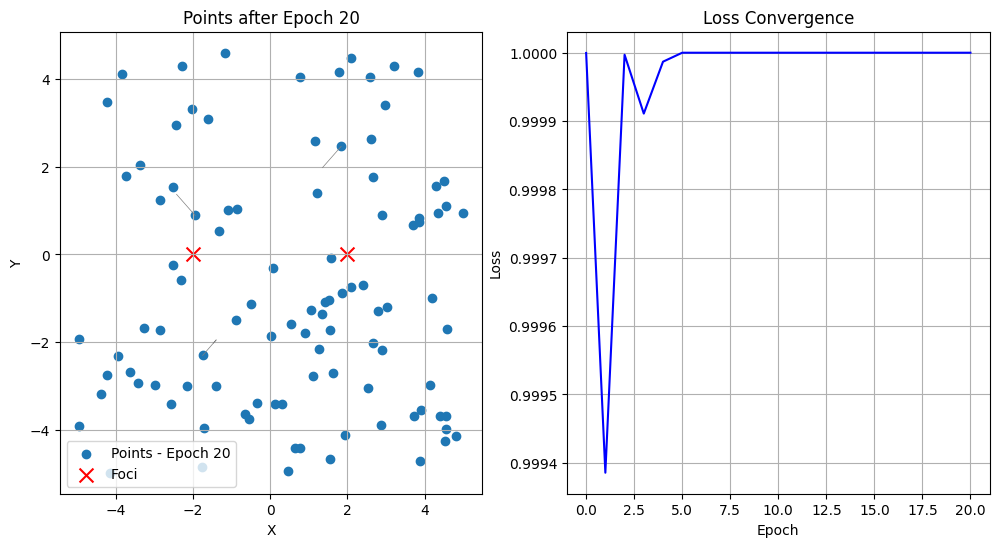

Epoch 20: Loss = 1.000000


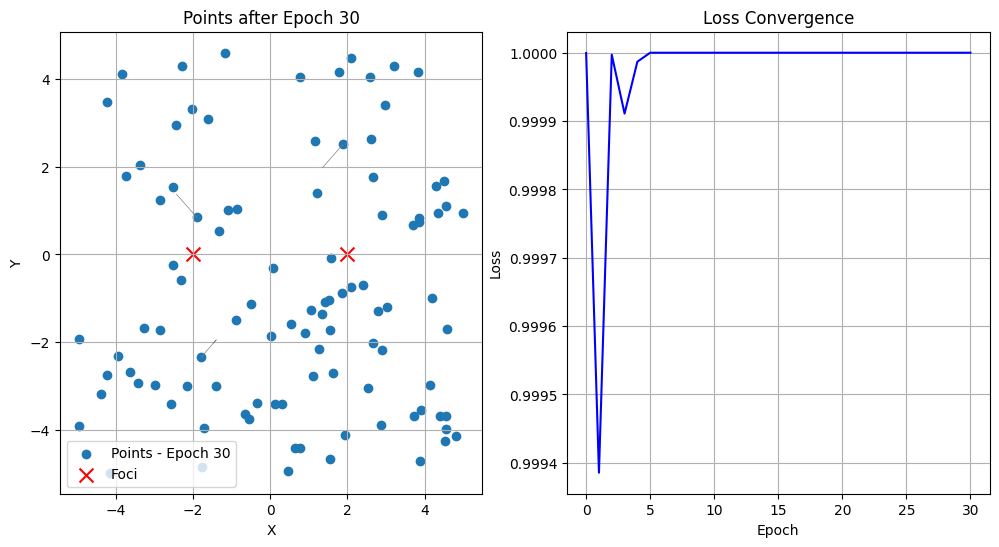

Epoch 30: Loss = 1.000000


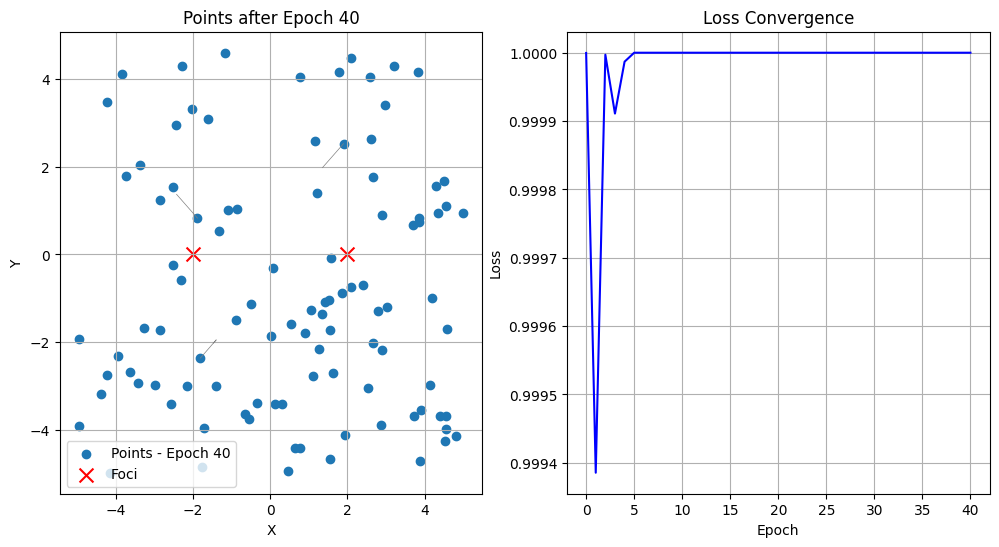

Epoch 40: Loss = 1.000000


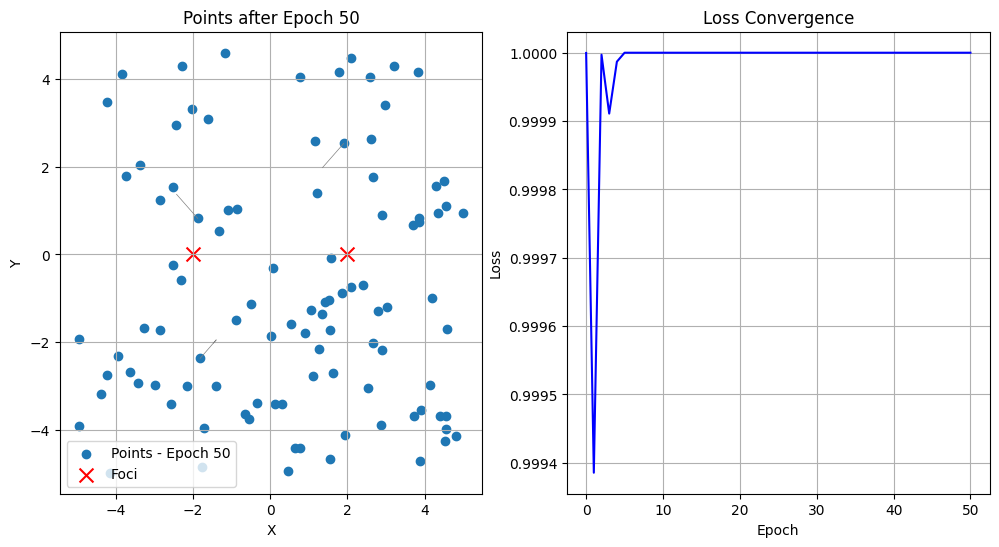

Epoch 50: Loss = 1.000000


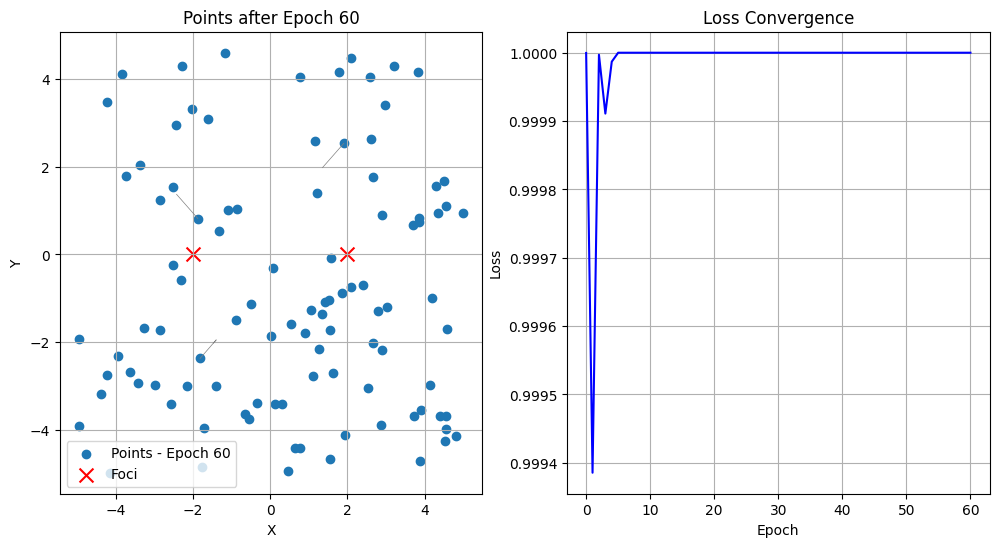

Epoch 60: Loss = 1.000000


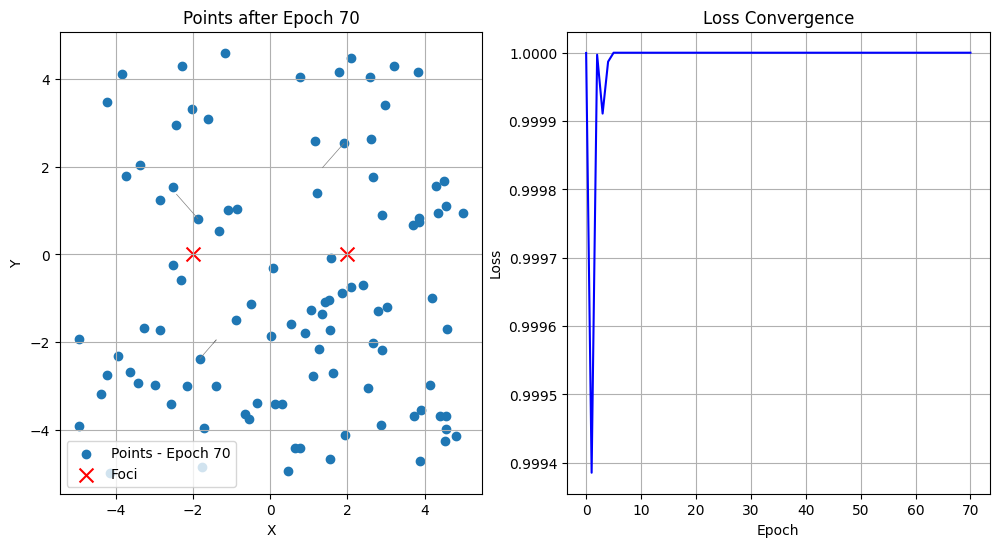

Epoch 70: Loss = 1.000000


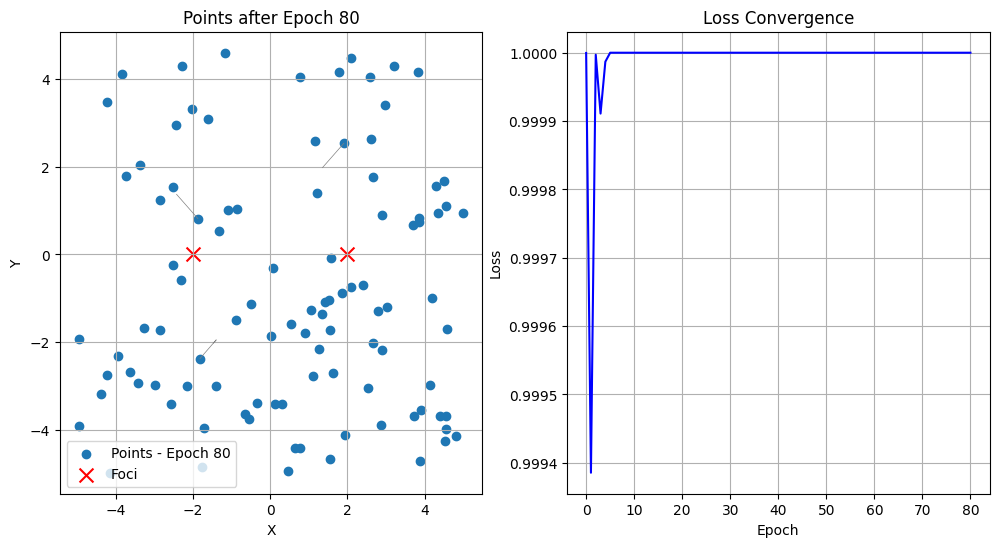

Epoch 80: Loss = 1.000000


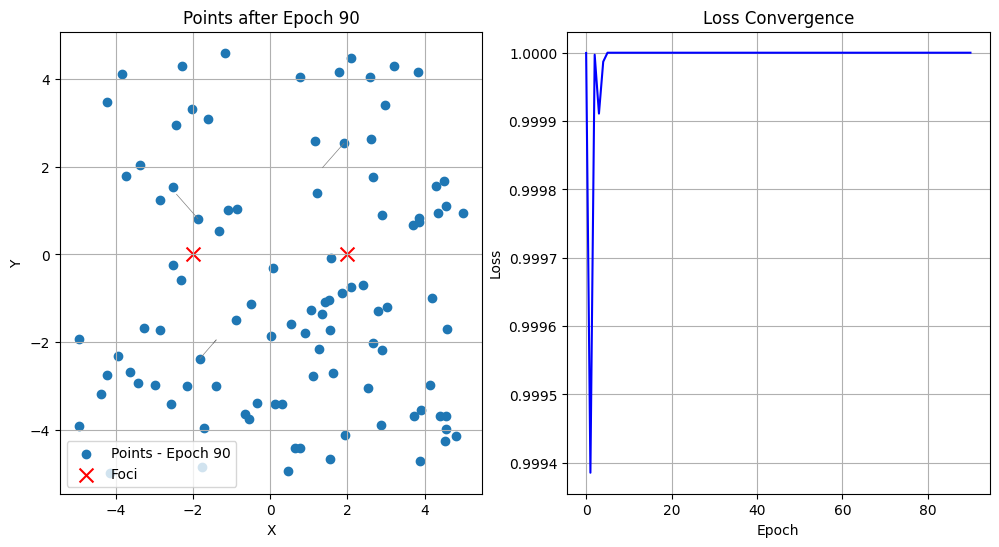

Epoch 90: Loss = 1.000000


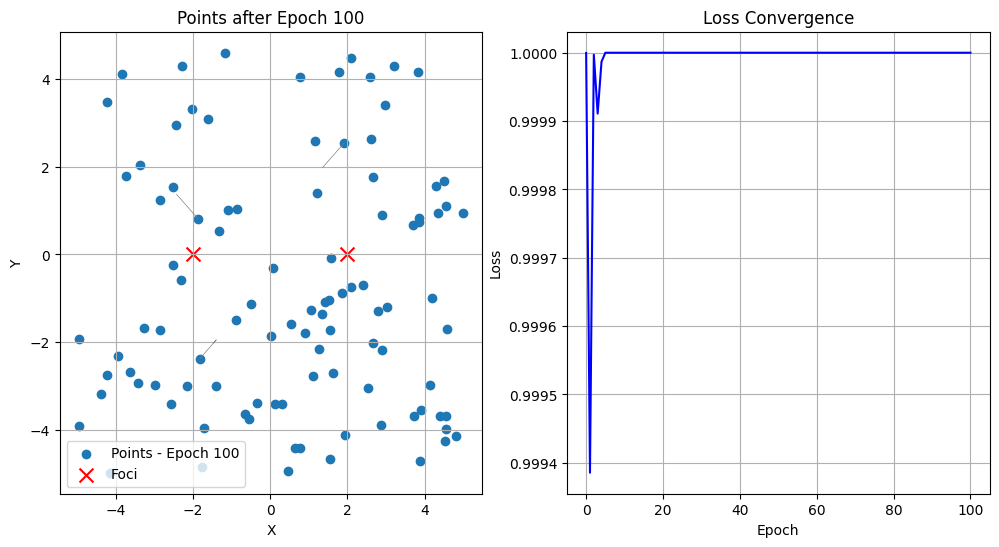

Epoch 100: Loss = 1.000000


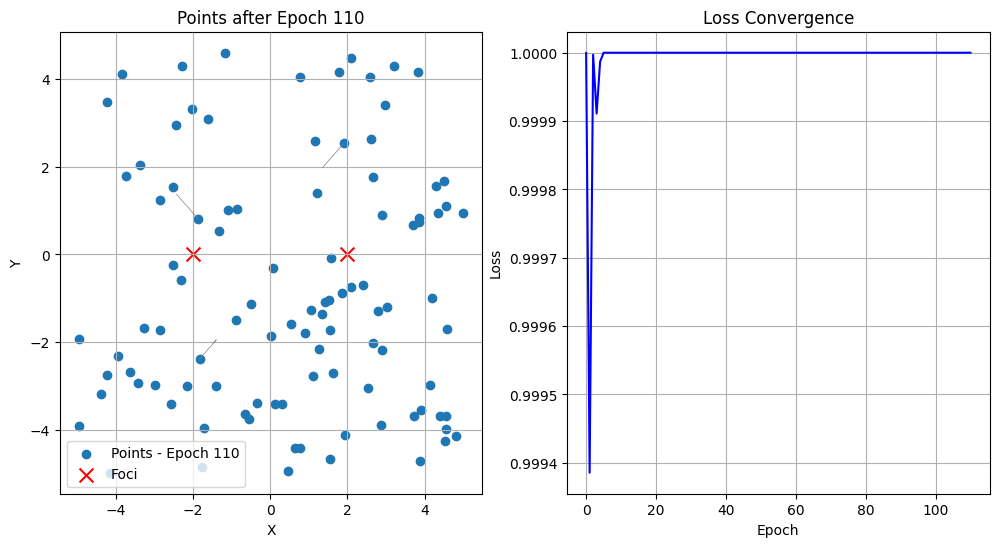

Epoch 110: Loss = 1.000000


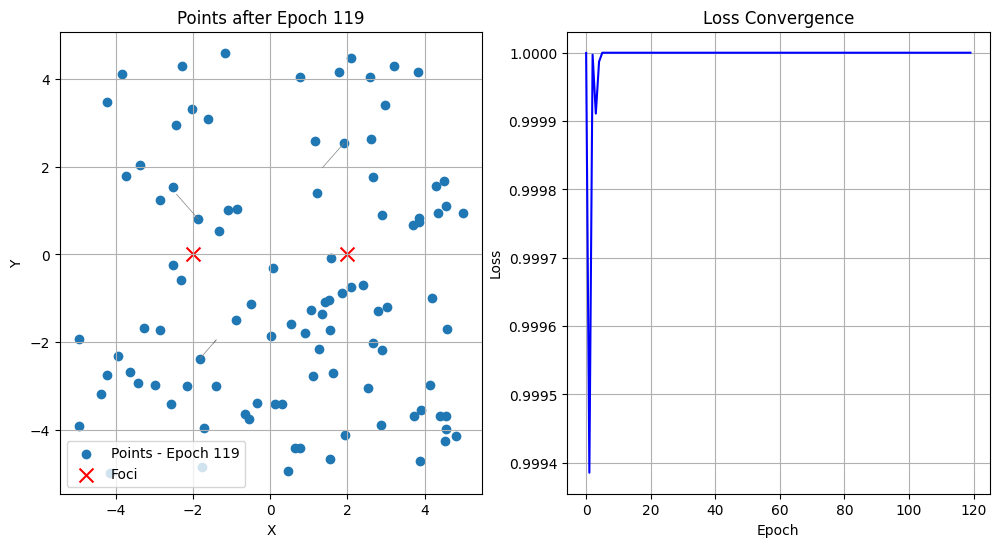

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []

def plot_results(epoch, trajectories, loss_history=None):
    if loss_history is not None:
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
      fig, axes = plt.subplots(1, 1, figsize=(6, 6))
      axes = [axes]
    points = np.array([trajectories[i][-1] for i in range(num_points)])
    # Left plot: Scatter of points with trajectories
    axes[0].scatter(points[:, 0], points[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()


    axes[0].grid()

    if loss_history is not None:
      axes[0].set_title(f'Points after Epoch {epoch}')
      # Right plot: Loss history
      axes[1].plot(loss_history, color='blue')
      axes[1].set_xlabel("Epoch")
      axes[1].set_ylabel("Loss")
      axes[1].set_title("Loss Convergence")
      axes[1].grid()
    else:
      axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()


def training_loop(loss_function, points, num_epochs=1000, learning_rate=0.1):
  trajectories = [[] for _ in range(num_points)]
  loss_history = []
  optimizer = torch.optim.Adam([points], lr=learning_rate)
  for epoch in range(num_epochs):

      # zero-out all gradients
      optimizer.zero_grad()

      # Compute loss
      loss = loss_function(points)

      loss.backward()
      optimizer.step()

      loss_history.append(loss.item())

      # Store current positions for tracking movement
      for i in range(num_points):
          trajectories[i].append(points[i].detach().cpu().clone().numpy())

      # Plot results every 10th epoch
      if epoch % 10 == 0:
          plot_results(epoch, trajectories, loss_history)

      if epoch % 10 == 0:
          print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

  plot_results(epoch, trajectories, loss_history)


def loss_L0(points, epsilon=1e-3):
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    sum_distances = dist1 + dist2

    error = torch.abs(sum_distances - constant_sum)
    smooth_step = torch.sigmoid(100.0 * (error - epsilon))
    return smooth_step.mean()


training_loop(loss_L0, points)


In training process we can use various types of functions which computes loss depending on $\epsilon_i = d_{i1} + d_{i2} - C$:


## $L^2$ loss (used in class):
$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

In [ ]:
def loss_L2(points):
  d1 = torch.norm(points - focus1, dim=1)
  d2 = torch.norm(points - focus2, dim=1)
  sum_distances = d1 + d2
  return torch.mean((sum_distances - constant_sum) ** 2)

## $L^0$ loss

$$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
$$

Problem with function defined as above is that the function is not differentiable. It causes error in `loss.backward()` function.\
Furthermore, the condition $ \epsilon_i \neq 0$ is, in practice, always true because in float arithmetics it is almost impossible to obtain $0$ as a result.\\
To omit these problems, I use scaled and shifted sigmoid function gives as follows:
$$
\tilde{\sigma}(x)=\frac{2}{1+e^{-x}}-1
$$
